## 6.5: Unsupervised Machine Learning: Clustering

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [2]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Reset the maximum number of columns to display to default (all columns)

pd.set_option('display.max_columns', None)

In [4]:
# Change the format of the values visualization

pd.options.display.float_format = '{:.2f}'.format

In [5]:
# Defining the path to datasets

path = r'C:\Users\efens\cf_tasks\2023-08 Steam Analysis'

#### Importing dataframe

In [6]:
# Importing project data "steam_merged"

steam_merged = pd.read_csv(os.path.join(path, '02 Data', '022 Prepared Data', 'steam_merged.csv'))

In [7]:
steam_merged.shape

(27233, 27)

In [8]:
steam_merged.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,price_eur,owners_min,owners_max,owners_avg,gameplay_type,dev_year,country,city,administrative_division
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,8.34,10000000,20000000,15000000.00,Multi-Player,1996.00,United States,Kirkland,Washington
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,4.63,5000000,10000000,7500000.00,Multi-Player,1996.00,United States,Kirkland,Washington
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,4.63,5000000,10000000,7500000.00,Multi-Player,1996.00,United States,Kirkland,Washington


#### Preparing a new dataframe for clustering

In [10]:
steam_cluster = steam_merged[['positive_ratings', 'negative_ratings', 'average_playtime', 'price_eur', 'owners_avg']]

In [11]:
steam_cluster.head()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
0,124534,3339,17612,8.34,15000000.00
1,3318,633,277,4.63,7500000.00
2,3416,398,187,4.63,7500000.00
3,1273,267,258,4.63,7500000.00
4,5250,288,624,4.63,7500000.00


In [12]:
# Checking missing values

missing_steam = steam_cluster.isnull().sum()
missing_steam

positive_ratings    0
negative_ratings    0
average_playtime    0
price_eur           0
owners_avg          0
dtype: int64

In [13]:
# Checking for duplicates

dups = steam_cluster[steam_cluster.duplicated()]
dups

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
31,472,158,182,8.34,750000.00
33,1602,152,65,8.11,750000.00
35,2057,344,80,8.34,750000.00
37,368,75,121,8.34,750000.00
126,363721,16433,12422,8.11,15000000.00
...,...,...,...,...,...
27228,3,0,0,2.42,10000.00
27229,8,1,0,1.96,10000.00
27230,0,1,0,4.63,10000.00
27231,2,0,0,6.02,10000.00


In [14]:
# Removing duplicates

steam_cluster_clean = steam_cluster.drop_duplicates()

In [15]:
# Checking for duplicates

dups = steam_cluster_clean[steam_cluster_clean.duplicated()]
dups

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg


#### Additional check

In [16]:
steam_cluster_clean.shape

(19279, 5)

In [17]:
steam_cluster_clean.head()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
0,124534,3339,17612,8.34,15000000.00
1,3318,633,277,4.63,7500000.00
2,3416,398,187,4.63,7500000.00
3,1273,267,258,4.63,7500000.00
4,5250,288,624,4.63,7500000.00


In [18]:
steam_cluster_clean.describe()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
count,19279.00,19279.00,19279.00,19279.00,19279.00
mean,1402.38,295.38,210.38,8.14,184244.51
std,22490.57,5075.53,2162.23,10.38,1571104.24
min,0.00,0.00,0.00,0.00,10000.00
25%,18.00,6.00,0.00,2.31,10000.00
50%,55.00,20.00,0.00,5.79,10000.00
75%,247.00,76.00,58.00,11.59,75000.00
max,2644404.00,487076.00,190625.00,489.51,150000000.00


#### Removing outliers

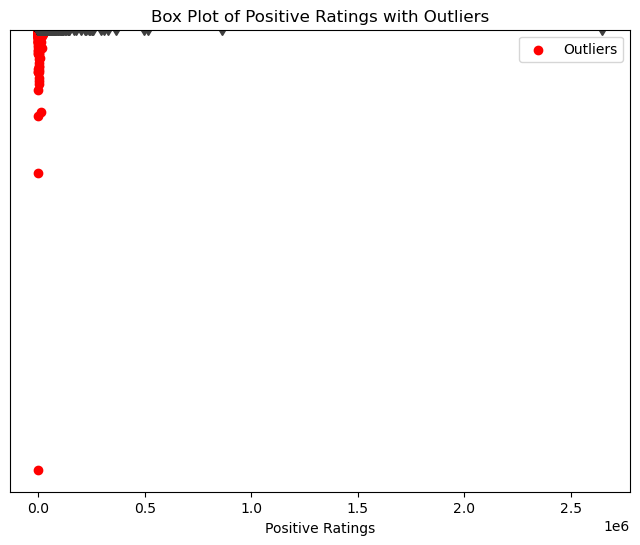

In [19]:
# Create a box plot for positive_ratings

plt.figure(figsize=(8, 6))
sns.boxplot(x=steam_cluster_clean['positive_ratings'])

# Identify and mark outliers

Q1 = steam_cluster_clean['positive_ratings'].quantile(0.25)
Q3 = steam_cluster_clean['positive_ratings'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = steam_cluster_clean[(steam_cluster_clean['positive_ratings'] < lower_bound) | (steam_cluster_clean['positive_ratings'] > upper_bound)]
plt.scatter(outliers.index, outliers['positive_ratings'], color='red', label='Outliers')

plt.xlabel('Positive Ratings')
plt.title('Box Plot of Positive Ratings with Outliers')
plt.legend()
plt.show()

In [20]:
outliers = steam_cluster_clean[(steam_cluster_clean['positive_ratings'] < lower_bound) | (steam_cluster_clean['positive_ratings'] > upper_bound)]
outliers.shape

(2962, 5)

In [21]:
outliers.describe()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
count,2962.00,2962.00,2962.00,2962.00,2962.00
mean,8620.38,1720.04,840.43,12.77,986880.49
std,56847.05,12856.64,2871.17,12.08,3908099.43
min,591.00,10.00,0.00,0.00,10000.00
25%,998.25,176.00,75.00,4.05,150000.00
50%,1865.50,386.00,234.00,10.43,350000.00
75%,4933.50,1024.25,613.00,17.39,750000.00
max,2644404.00,487076.00,63481.00,81.19,150000000.00


In [22]:
# Calculate the lower and upper bounds for each column using the IQR method

Q1 = steam_cluster_clean.quantile(0.25)
Q3 = steam_cluster_clean.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask to identify outliers in the entire dataset

outlier_mask = ((steam_cluster_clean < (lower_bound - 1e-5)) | (steam_cluster_clean > (upper_bound + 1e-5)))

# Remove rows containing outliers

steam_cluster_clean_no_outliers = steam_cluster_clean[~outlier_mask.any(axis=1)]

- steam_cluster_clean_no_outliers now contains the dataset with outliers removed

In [23]:
steam_cluster_clean_no_outliers.shape

(13335, 5)

In [24]:
steam_cluster_clean_no_outliers.describe()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg
count,13335.00,13335.00,13335.00,13335.00,13335.00
mean,71.36,22.72,3.52,6.43,21363.33
std,100.00,30.03,17.00,5.35,26566.79
min,0.00,0.00,0.00,0.00,10000.00
25%,13.00,4.00,0.00,1.96,10000.00
50%,32.00,11.00,0.00,5.56,10000.00
75%,83.00,28.00,0.00,8.34,10000.00
max,590.00,181.00,145.00,25.51,150000.00


#### Exporting a data without outliers

In [25]:
steam_cluster_clean_no_outliers.to_csv(os.path.join(path, '02 Data','022 Prepared Data', 'steam_cluster_no_outliers.csv'), header=True, index=False)

#### Importing back

In [26]:
# Importing project data "steam_cluster_no_outliers"

steam_no_outliers = pd.read_csv(os.path.join(path, '02 Data', '022 Prepared Data', 'steam_cluster_no_outliers.csv'))

## 01. The elbow technique

In [27]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [28]:
score = [kmeans[i].fit(steam_no_outliers).score(steam_no_outliers) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_k

In [29]:
score

[-9411214256889.482,
 -2412899330738.482,
 -932990731633.1575,
 -107230163.57118368,
 -80760294.49562697,
 -56215891.23434163,
 -45274434.93738428,
 -40038903.00859228,
 -34264351.40215944]

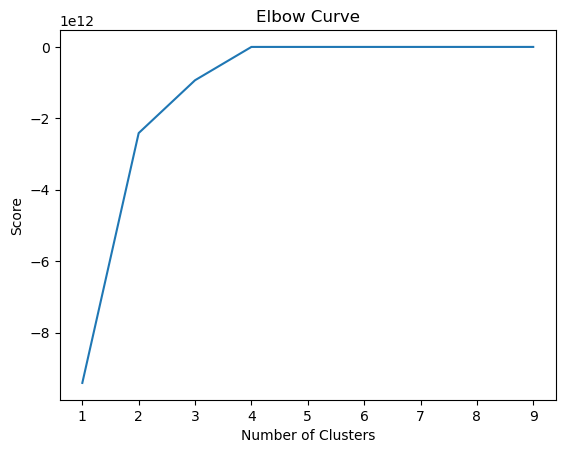

In [30]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

- Based on the graph, it is evident that there are four distinct clusters. 
- The first and second clusters exhibit a higher degree of separation and identification.

## 02. k-means clustering

In [31]:
# Create the k-means object.

kmeans = KMeans(n_clusters = 4) 
# n_jobs: This parameter controls the number of CPU cores to use for the computation. A value of -1 means to use all available CPU cores.

In [32]:
# Fit the k-means object to the data.

kmeans.fit(steam_no_outliers)

D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [33]:
steam_no_outliers['clusters'] = kmeans.fit_predict(steam_no_outliers)

D:\Programming\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
steam_no_outliers.head()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg,clusters
0,40,17,0,6.95,35000.00,3
1,468,61,0,8.34,150000.00,2
2,112,26,0,8.11,75000.00,1
3,451,108,0,5.79,150000.00,2
4,490,152,9,5.79,150000.00,2


In [35]:
steam_no_outliers['clusters'].value_counts()

0    10058
3     2150
1      800
2      327
Name: clusters, dtype: int64

In [36]:
# Exporting clusters

steam_no_outliers.to_csv(os.path.join(path, '02 Data','022 Prepared Data', 'steam_clusters.csv'), header=True, index=False)

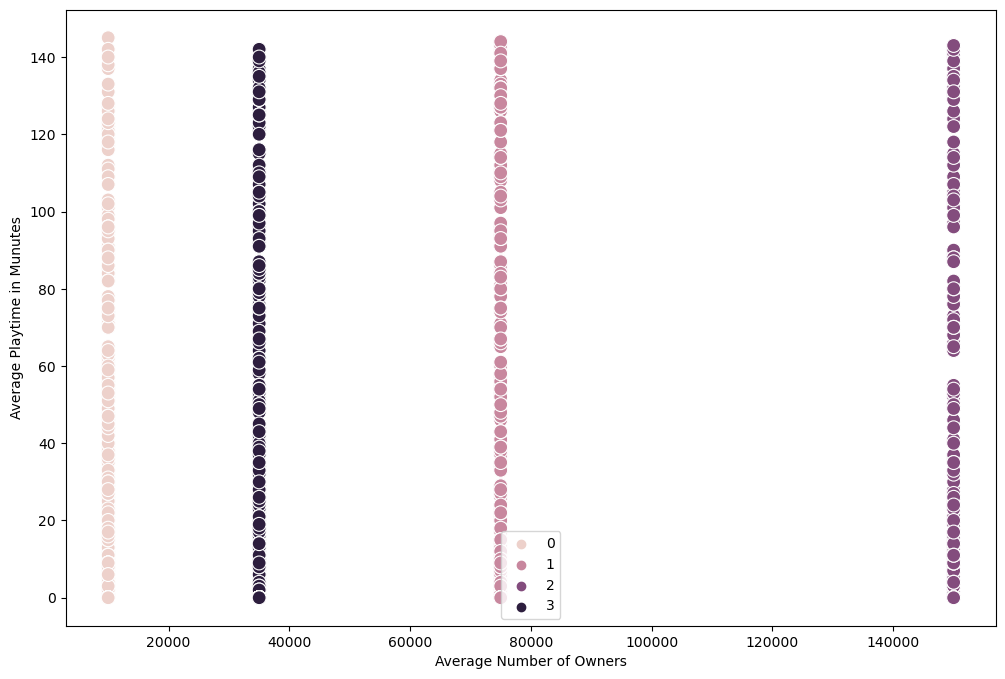

In [37]:
# Plot the clusters for the "owners_avg" and "average_playtime" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=steam_no_outliers['owners_avg'], y=steam_no_outliers['average_playtime'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Average Number of Owners') # Label x-axis.
plt.ylabel('Average Playtime in Munutes') # Label y-axis.
plt.show()

- Looking at this graph we can say that the average amount of play in minutes does not differ between games with different numbers of owners. 

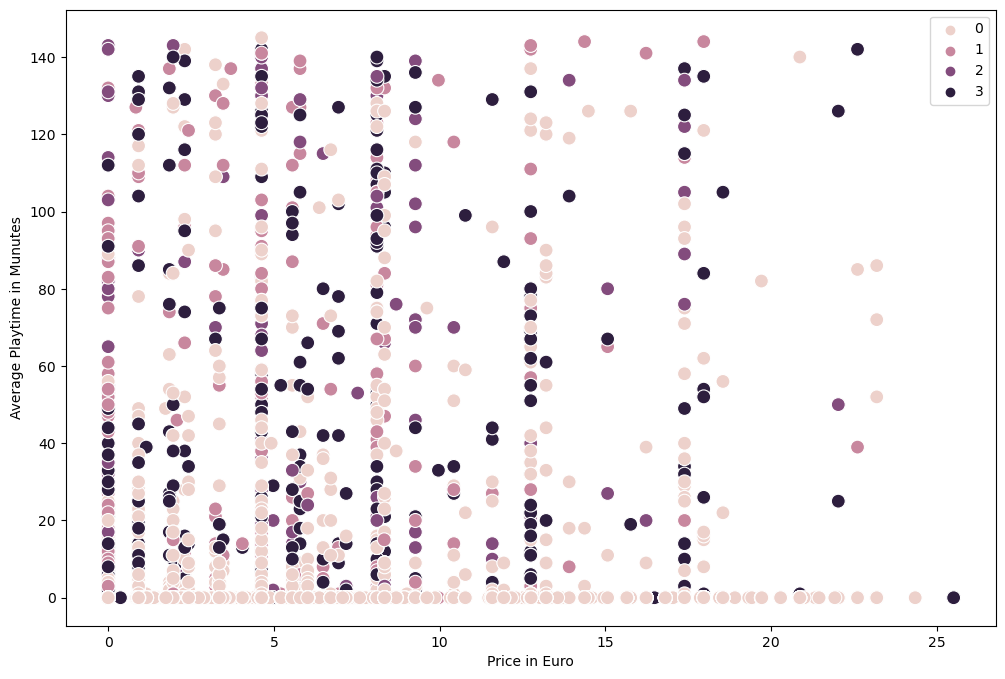

In [38]:
# Plot the clusters for the "average_playtime" and "price_eur" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=steam_no_outliers['price_eur'], y=steam_no_outliers['average_playtime'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Price in Euro') # Label x-axis.
plt.ylabel('Average Playtime in Munutes') # Label y-axis.
plt.show()

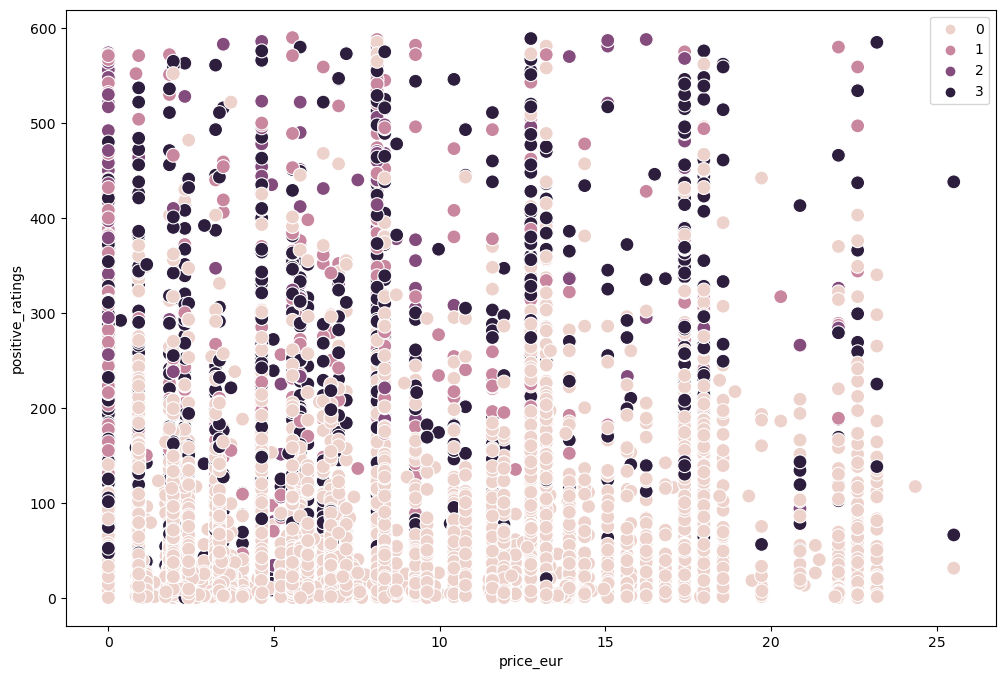

In [39]:
# Plot the clusters for the "positive_ratings" and "price_eur" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=steam_no_outliers['price_eur'], y=steam_no_outliers['positive_ratings'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('price_eur') # Label x-axis.
plt.ylabel('positive_ratings') # Label y-axis.
plt.show()

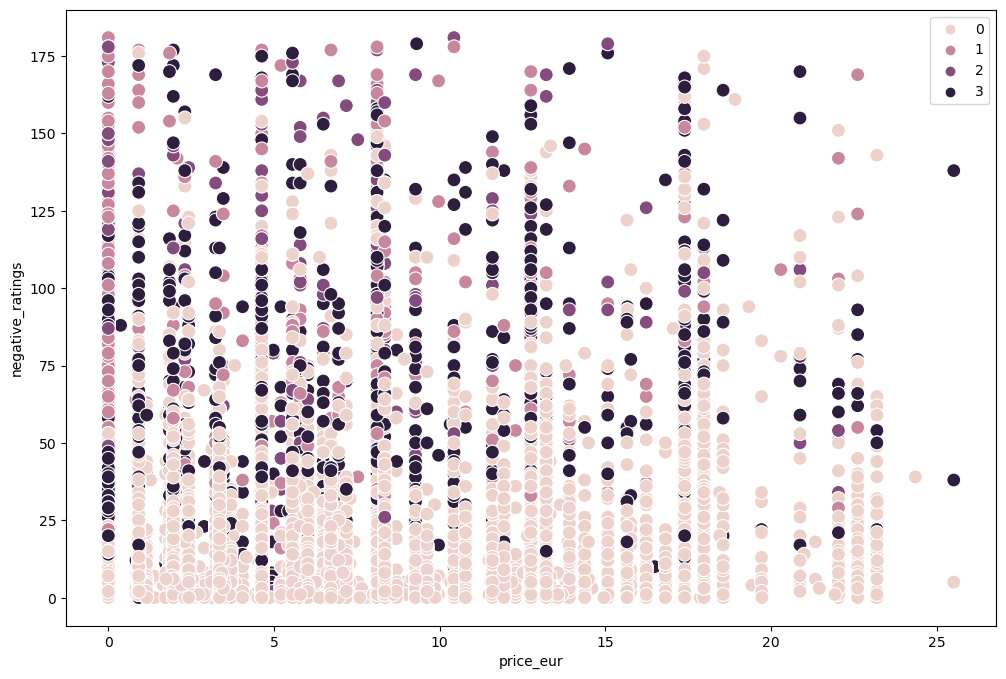

In [40]:
# Plot the clusters for the "negative_ratings" and "price_eur" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=steam_no_outliers['price_eur'], y=steam_no_outliers['negative_ratings'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('price_eur') # Label x-axis.
plt.ylabel('negative_ratings') # Label y-axis.
plt.show()

In [41]:
steam_no_outliers.loc[steam_no_outliers['clusters'] == 3, 'cluster'] = 'dark purple'
steam_no_outliers.loc[steam_no_outliers['clusters'] == 2, 'cluster'] = 'purple'
steam_no_outliers.loc[steam_no_outliers['clusters'] == 1, 'cluster'] = 'pink'
steam_no_outliers.loc[steam_no_outliers['clusters'] == 0, 'cluster'] = 'light pink'

In [42]:
steam_no_outliers.groupby('cluster').agg({'positive_ratings':['mean', 'median'], 
                         'negative_ratings':['mean', 'median'], 
                         'average_playtime':['mean', 'median'],
                          'price_eur':['mean', 'median'],
                          'owners_avg':['mean', 'median']          
                                         })

positive_ratings        negative_ratings        average_playtime  \
                        mean median             mean median             mean   
cluster                                                                        
dark purple           132.00  83.00            40.11  31.00             6.56   
light pink             43.11  23.00            13.76   8.00             1.40   
pink                  187.93 155.00            62.47  53.00            13.71   
purple                256.43 229.00            86.81  84.00            23.99   

                   price_eur        owners_avg            
            median      mean median       mean    median  
cluster                                                   
dark purple   0.00      5.63   4.63   35000.00  35000.00  
light pink    0.00      6.76   5.56   10000.00  10000.00  
pink          0.00      4.90   4.63   75000.00  75000.00  
purple        0.00      5.11   4.63  150000.00 150000.00

In [43]:
steam_no_outliers.describe()

,positive_ratings,negative_ratings,average_playtime,price_eur,owners_avg,clusters
count,13335.00,13335.00,13335.00,13335.00,13335.00,13335.00
mean,71.36,22.72,3.52,6.43,21363.33,0.59
std,100.00,30.03,17.00,5.35,26566.79,1.12
min,0.00,0.00,0.00,0.00,10000.00,0.00
25%,13.00,4.00,0.00,1.96,10000.00,0.00
50%,32.00,11.00,0.00,5.56,10000.00,0.00
75%,83.00,28.00,0.00,8.34,10000.00,0.00
max,590.00,181.00,145.00,25.51,150000.00,3.00


In [44]:
steam_no_outliers['clusters'].value_counts()

0    10058
3     2150
1      800
2      327
Name: clusters, dtype: int64

## Step 8: Discuss how and why the clusters make sense.

1. In general, the clusters appear quite logical, as they group games based on their popularity, user ratings, playtime, price, and ownership. Games in the "dark purple" and "pink" clusters have a higher number of ratings and were added by more people to their library. In the "purple" cluster, there are games with the lowest number of ratings in the ranking, less playtime, but they are the most expensive.



2. These clusters can provide insights into the characteristics and preferences of different segments of the gaming market, but more detailed data about Steam users are needed, such as the number of downloads of the games, rather than just the number of people adding them to their library.



3. It's also important to remember that a large number of values were filtered out of the dataset as they were outliers. Therefore, practically all quantitative values represent average values and may not accurately reflect the true nature.



4. The knowledge gained during the cluster analysis can serve as a foundation for future research and planning, focusing on various segments of the gaming market.

#### Clusters in numbers:

- Light pink (0) = 10,058 values → The cluster with the smallest number of ratings, the smallest average playtime, and the fewest owners but the highest price.

- Dark purple (3) = 2,150 values → This cluster has higher numbers in all variables.

- Pink (1) = 800 values → This cluster has high numbers in all variables but the lowest price (according to the average value of 4.90).

- Purple (2) = 327 values → The cluster with the highest numbers in rating numbers, average playtime, and number of owners, but with a price higher than in the 3rd cluster.